# Biomedicina: Entrenamiento y clasificacion de datos EEG

In [1]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import radviz
import matplotlib.pyplot as plt
from time import time

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
#from sklearn.pipeline import Pipeline
#from sklearn.kernel_approximation import (RBFSampler, Nystroem)
import seaborn as sns; sns.set()

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 12

## Preprocesado de datos

In [3]:
s1 = '/home/cramos/Dropbox/BIO/train_subject1_psd01.asc'
s2 = '/home/cramos/Dropbox/BIO/train_subject1_psd02.asc'
s3 = '/home/cramos/Dropbox/BIO/train_subject1_psd03.asc'
t  = '/home/cramos/Dropbox/BIO/test_subject1_psd04.asc'
yr = '/home/cramos/Dropbox/BIO/res_subject1_raw.asc'
etiquetas = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 
             'CP1', 'CP5', 'P7', 'P3', 'Pz' , 'PO3', 'O1', 'Oz', 
             'O2' , 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 
             'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 
             'Clase']
sub1 = pd.read_fwf(s1, names=etiquetas)
sub2 = pd.read_fwf(s2, names=etiquetas)
sub3 = pd.read_fwf(s3, names=etiquetas)
tst  = pd.read_fwf(t, names=etiquetas[:32])
y_r  = pd.read_fwf(yr)


Tomamos los 3 datasets de entrenamiento y los concatenamos en un solo dataframe (subs).

In [4]:
frames = [sub1, sub2, sub3]
subs = pd.concat(frames)

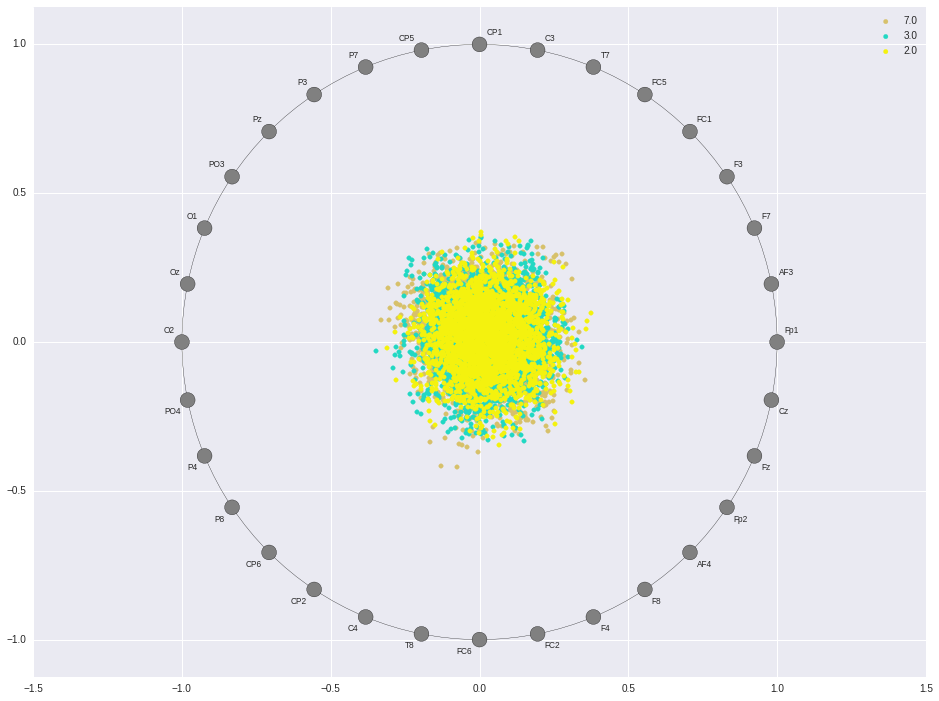

In [5]:
radviz(subs, 'Clase')

### Construcción de matrices de entrenamiento

In [6]:
X = subs.iloc[:,0:32].values
y = subs.iloc[:,32:].values

In [7]:
Xt = tst.iloc[:,0:32].values
y_real = np.matrix(y_r)

In [8]:
y = np.ravel(y)

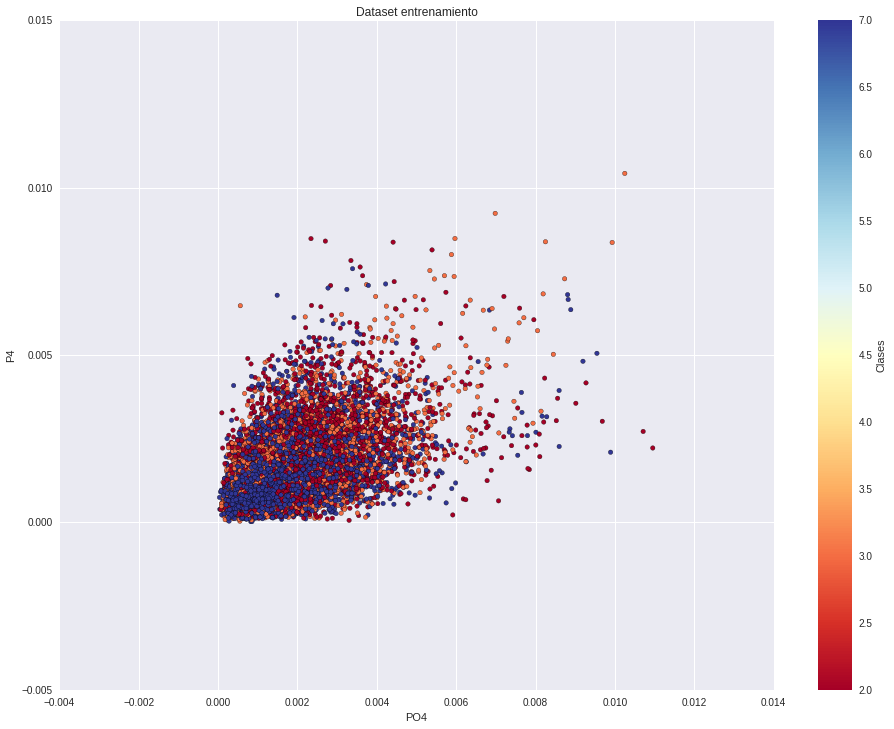

In [9]:
x_ind = 6
y_ind = 7

plt.scatter(X[:,x_ind], X[:,y_ind], c=y, cmap='RdYlBu')
plt.title('Dataset entrenamiento')
plt.ylabel(etiquetas[y_ind]),
plt.xlabel(etiquetas[x_ind])
plt.colorbar(label='Clases')

## Entrenamiento

In [10]:
# Número de muestras
n_samples = X.shape[0]

# Número de características
n_features = X.shape[1]

# Número de clases
n_classes = np.unique(y).shape[0]


print("Tamaño total de dataset")
print("Muestras: %d" % n_samples)
print("Características: %d" % n_features)
print("Clases: %d \n\n" % n_classes)

###############################################################################
# Cross-validation, separación de muestras a set de entrenamiento y 
# test (ratio 0.75/0.25 entrenamiento/test)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Entrenamiento de clasificador SVM con el conjunto de entrenamiento

print("* Ajustando el clasificador SVM con el conjunto de entrenamiento")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 2], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train, y_train)
print("finalizado en %0.3fs \n\n" % (time() - t0))
print("Mejor estimador encontrado mediante grid search:")
print(clf.best_estimator_)
clf = clf.best_estimator_

###############################################################################
# Evaluación cuantitativa de la calidad del modelo en el set de testeo

print("* Predicción de las clases del test set")
t0 = time()
y_pred = clf.predict(X_test)
print("finalizado en %0.3fs \n\n" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


Tamaño total de dataset
Muestras: 10528
Características: 32
Clases: 3 


* Ajustando el clasificador SVM con el conjunto de entrenamiento
finalizado en 674.168s 


Mejor estimador encontrado mediante grid search:
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
* Predicción de las clases del test set
finalizado en 1.066s 


             precision    recall  f1-score   support

        2.0       0.62      0.70      0.65       775
        3.0       0.62      0.48      0.54       864
        7.0       0.64      0.70      0.67       993

avg / total       0.63      0.63      0.62      2632

[[  0   0   0]
 [  0   0   0]
 [  0   0 541]]


## Clasificación

In [11]:
Xtt = X[:470]
Yt = clf.predict(Xtt)
Ytm=np.matrix(Yt)

In [12]:
print(confusion_matrix(Ytm.T,y_real))
print(classification_report(Ytm.T,y_real))

[[17 34 20]
 [37 45 71]
 [88 59 99]]
             precision    recall  f1-score   support

        2.0       0.12      0.24      0.16        71
        3.0       0.33      0.29      0.31       153
        7.0       0.52      0.40      0.45       246

avg / total       0.40      0.34      0.36       470



Después de predecir volvemos a construir el dataframe con los resultados:

In [18]:
Xt.shape, Ytm.shape
subt = np.concatenate((Xtt,Ytm.T), axis=1)

In [19]:
subt = pd.DataFrame(subt, columns=etiquetas)

## Ploteo de resultados

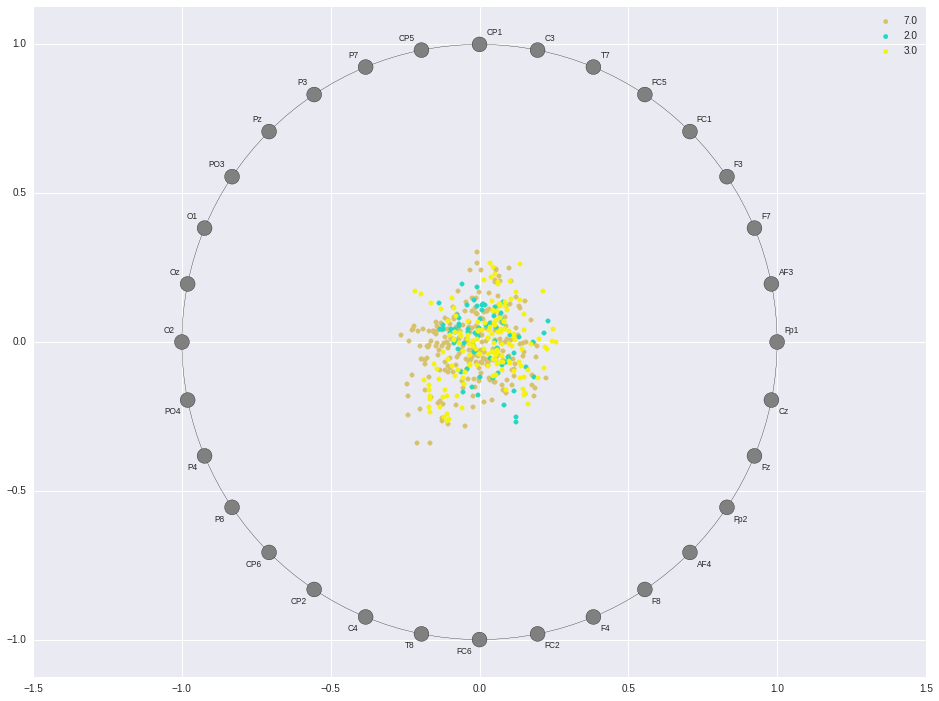

In [20]:
radviz(subt, 'Clase')

In [21]:
Yt_r = np.array(Yt).T[:][:470]

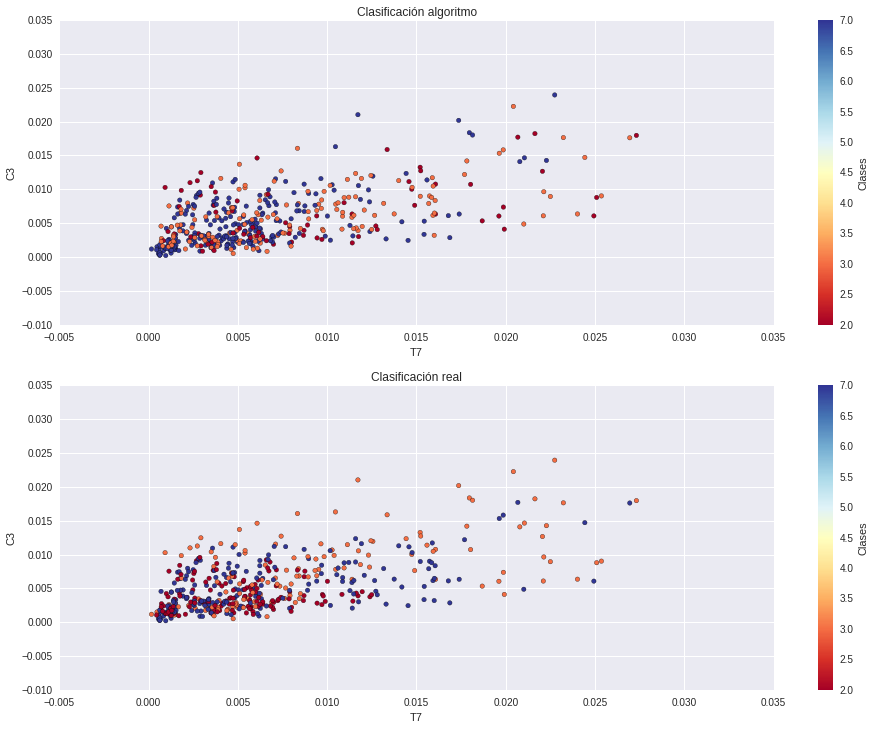

In [22]:
x_ind = 6
y_ind = 7

plt.subplot(2, 1, 1)
plt.scatter(Xtt[:,x_ind], Xtt[:,y_ind], c=np.array(Yt_r), cmap='RdYlBu')
plt.title('Clasificación algoritmo')
plt.ylabel(etiquetas[y_ind]),
plt.xlabel(etiquetas[x_ind])
plt.colorbar(label='Clases')

plt.subplot(2, 1, 2)
plt.scatter(Xtt[:,x_ind], Xtt[:,y_ind], c=np.array(y_real), cmap='RdYlBu')
plt.title('Clasificación real')
plt.ylabel(etiquetas[y_ind]),
plt.xlabel(etiquetas[x_ind])
plt.colorbar(label='Clases',)

plt.show()